In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-fs-prebuilt' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-source-440-server' for glob 'nvidia*'


In [3]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-source-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-331-updates-uvm' for glob 'nvidi

In [4]:
!nvcc --version

/bin/bash: nvcc: command not found


In [5]:
import torch
torch.cuda.is_available()

True

In [6]:
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [8]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-xjzrm_5_
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-xjzrm_5_
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 58 kB 4.5 MB/s 
     |████████████████████████████████| 376 kB 21.2 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.0-py3-none-any.whl size=102076 sha256=001571113d3bcf41ef57ff1e84a91e9e6d2a7b022514918270a56609750a2044
  Stored in directory: /tmp/pip-ephem-wheel-cache-nbuwdg_7/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=653db9da8a5ab07166aef

In [9]:
import segmentation_models_pytorch as smp

In [10]:

DATA_DIR_tr = '/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/translated_train_val_test/train/'
x_train_dir = os.path.join(DATA_DIR_tr, 'image')
y_train_dir = os.path.join(DATA_DIR_tr, 'mask')

DATA_DIR_test = '/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/translated_train_val_test/val/'

x_valid_dir = os.path.join(DATA_DIR_test, 'image')
y_valid_dir = os.path.join(DATA_DIR_test, 'mask')

In [ ]:
for file in os.listdir(x_train_dir):
  print(file)

In [11]:
class_dict = pd.read_csv("/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/translated_image_mask_1466/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'water', 'car']
Class RGB values:  [[0, 0, 0], [1, 1, 1], [2, 2, 2]]


In [13]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'water', 'car']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'water', 'car']
Class RGB values:  [[0, 0, 0], [1, 1, 1], [2, 2, 2]]


In [14]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x


# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [15]:
class BuildingsDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

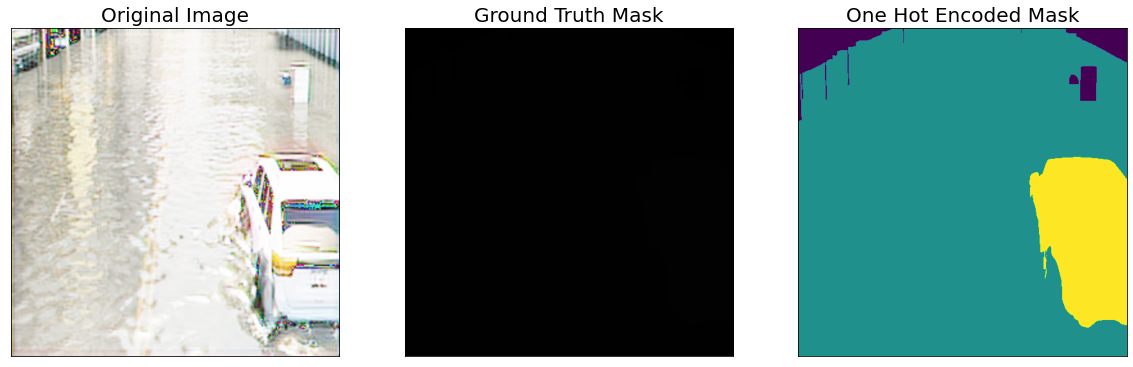

In [16]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [17]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                #album.VerticalFlip(p=1),
                #album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

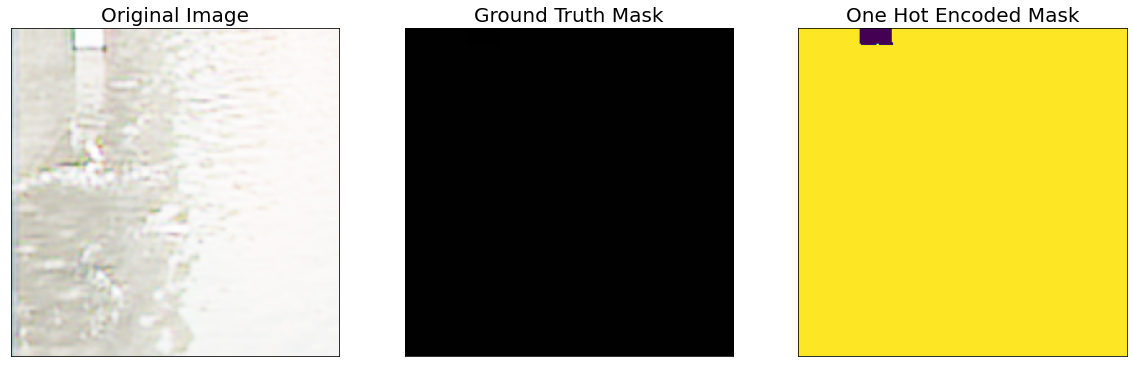

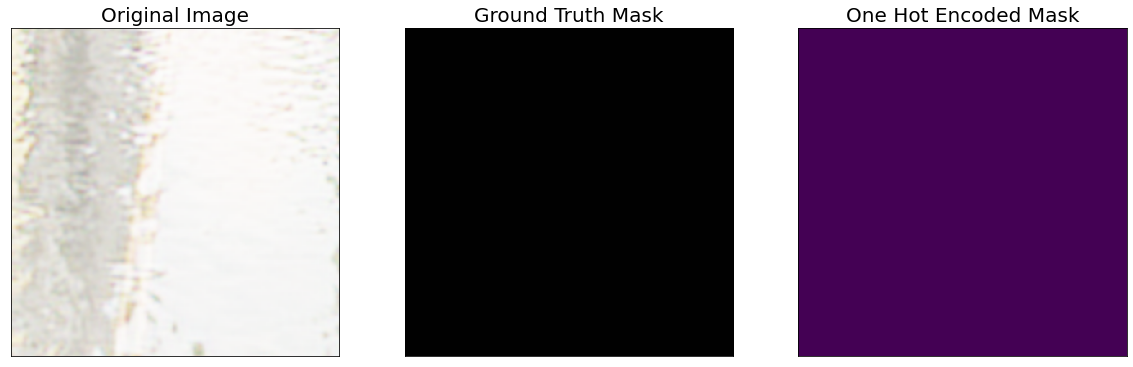

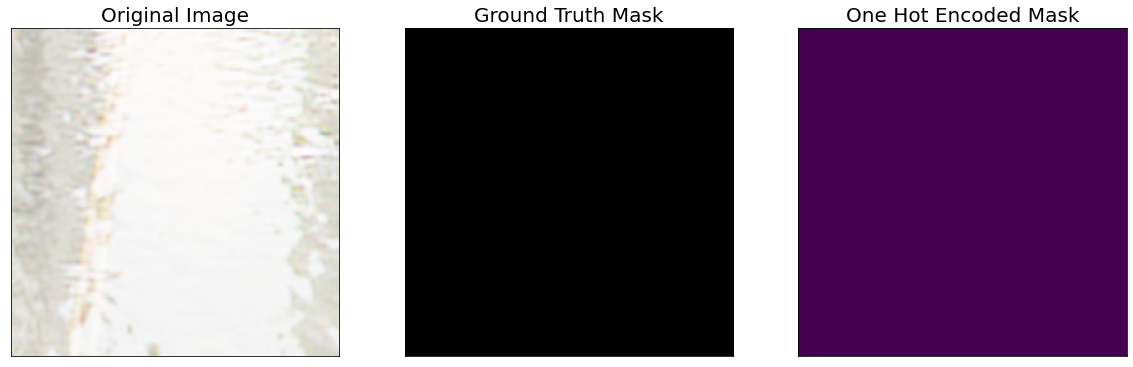

In [18]:
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [19]:
from torchsummary import summary
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'softmax' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
#summary(model,(3, 256, 256))

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [20]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=5)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

In [21]:
from segmentation_models_pytorch import utils

In [22]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 100

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics

metrics = [
    smp.utils.metrics.Recall(threshold=0.5),
   smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
   smp.utils.metrics.Precision(threshold=0.5),


]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

## load best saved model checkpoint from previous commit (if present)
#if os.path.exists('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model_resnot50_encoder.pth'):
    #model = torch.load('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model_resnot50_encoder.pth', map_location=DEVICE)

In [23]:


train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)



In [25]:
%%time

if TRAINING:

    best_iou_score = 0.0
    best_accuracy=0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_accuracy < valid_logs['accuracy']:
            best_accuracy = valid_logs['accuracy']
            torch.save(model, '/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/translated_image_mask_1466/best_model_resnot50_encoder_translated.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 822/822 [05:01<00:00,  2.73it/s, dice_loss - 0.02587, recall - 0.9832, fscore - 0.9836, accuracy - 0.9891, precision - 0.984]
Model saved!

Epoch: 1
valid: 100%|██████████| 822/822 [00:30<00:00, 26.84it/s, dice_loss - 0.01918, recall - 0.9853, fscore - 0.9855, accuracy - 0.9903, precision - 0.9857]
Model saved!

Epoch: 2
valid: 100%|██████████| 822/822 [00:30<00:00, 26.96it/s, dice_loss - 0.01461, recall - 0.9877, fscore - 0.9878, accuracy - 0.9919, precision - 0.9879]
Model saved!

Epoch: 3
valid: 100%|██████████| 822/822 [00:30<00:00, 26.89it/s, dice_loss - 0.01573, recall - 0.9869, fscore - 0.987, accuracy - 0.9914, precision - 0.9872]

Epoch: 4
valid: 100%|██████████| 822/822 [00:30<00:00, 26.88it/s, dice_loss - 0.01412, recall - 0.9872, fscore - 0.9873, accuracy - 0.9915, precision - 0.9873]

Epoch: 5
valid: 100%|██████████| 822/822 [00:31<00:00, 26.44it/s, dice_loss - 0.01246, recall - 0.9886, fscore - 0.9887, accuracy - 0.9924, precision - 0.988

In [38]:
DATA_DIR='/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/translated_train_val_test/test_data_translated/'
x_test_dir = os.path.join(DATA_DIR, 'image_64')
y_test_dir = os.path.join(DATA_DIR, 'mask_64')

In [35]:
# load best saved model checkpoint from the current run
if os.path.exists('/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/translated_image_mask_1466/best_model_resnot50_encoder_translated.pth'):
    best_model = torch.load('/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/translated_image_mask_1466/best_model_resnot50_encoder_translated.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

Loaded DeepLabV3+ model from this run.


In [ ]:
best_model.eval()

In [ ]:
best_model.encoder.layer4

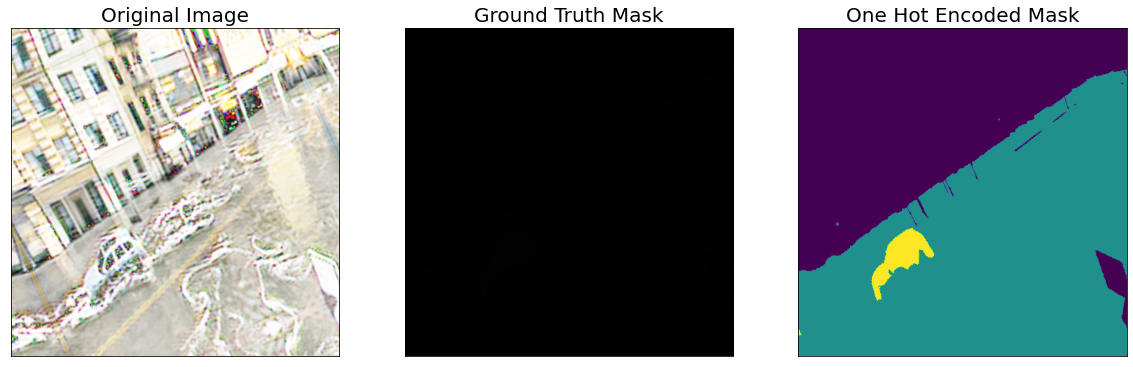

In [39]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [40]:
test_epoch = smp.utils.train.ValidEpoch(
    best_model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean Acc Score: {valid_logs['accuracy']:.4f}")
print(f"Mean DICE_loss : {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 64/64 [00:52<00:00,  1.22it/s, dice_loss - 0.006693, recall - 0.9934, fscore - 0.9934, accuracy - 0.9956, precision - 0.9934]
Evaluation on Test Data: 
Mean Acc Score: 0.9956
Mean DICE_loss : 0.0067


##Results with 1002 test data
valid: 100%|██████████| 1002/1002 [07:43<00:00,  2.16it/s, dice_loss - 0.006237, recall - 0.9938, fscore - 0.9938, accuracy - 0.9959, precision - 0.9938]
Evaluation on Test Data: 
Mean Acc Score: 0.9959
Mean DICE_loss : 0.0062

##results for 446 test data
valid: 100%|██████████| 446/446 [02:48<00:00,  2.65it/s, dice_loss - 0.006107, recall - 0.994, fscore - 0.994, accuracy - 0.996, precision - 0.994]
Evaluation on Test Data: 
Mean Acc Score: 0.9960
Mean DICE_loss : 0.0061

##results with 164 data
valid: 100%|██████████| 164/164 [01:05<00:00,  2.50it/s, dice_loss - 0.006525, recall - 0.9935, fscore - 0.9935, accuracy - 0.9957, precision - 0.9935]
Evaluation on Test Data: 
Mean Acc Score: 0.9957
Mean DICE_loss : 0.0065

##results with 64 data
valid: 100%|██████████| 64/64 [00:52<00:00,  1.22it/s, dice_loss - 0.006693, recall - 0.9934, fscore - 0.9934, accuracy - 0.9956, precision - 0.9934]
Evaluation on Test Data: 
Mean Acc Score: 0.9956
Mean DICE_loss : 0.0067

In [ ]:


# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[256,256,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]



In [ ]:
sample_preds_folder = '/content/gdrive/MyDrive/Flood_Project/Synthetic_Flood_Images_Blender/translated_image_mask_1466/sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_car_heatmap = pred_mask[:,:,select_classes.index('car')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_car_heatmap = pred_car_heatmap
    )